# 1. 데이콘 데이터 확인

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [35]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import os
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings("ignore")

In [36]:
pd.set_option('display.max_columns', 50)

In [37]:
# 데이터 불러오기
call = pd.read_csv("/content/drive/MyDrive/KGU/공모전/KT_빅데이터플랫폼_데이터셋/dlvr_call.csv")
weather = pd.read_csv("/content/drive/MyDrive/KGU/데이터생산/날씨.csv").drop("Unnamed: 0", axis=1)

In [38]:
call.head()

,SN,PROCESS_DT,DLVR_REQUST_ENTRPS_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_ENTRPS_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_BRTC_NM,DLVR_STORE_SIGNGU_NM,DLVR_STORE_LEGALDONG_NM,DLVR_STORE_LI_NM,DLVR_STORE_ADSTRD_CODE,DLVR_STORE_RDNMADR_CODE,DLVR_DSTN_LEGALDONG_CODE,DLVR_DSTN_BRTC_NM,DLVR_DSTN_SIGNGU_NM,DLVR_DSTN_LEGALDONG_NM,DLVR_DSTN_LI_NM,DLVR_DSTN_ADSTRD_CODE,DLVR_DSTN_RDNMADR_CODE,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_NM,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_RECPT_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME
0,3486929,2019-12-01,C000101,1,C000101,S0021950,족발/보쌈,1156013200,서울특별시,영등포구,신길동,\N,1156066000,115603000023,1159010800,서울특별시,동작구,대방동,\N,1159066000,115904157098,D0006140,3300,200,18000,1,승인:KB국민카드,2019-12-01 20:47:52,2019-12-01 20:48:11,2019-12-01 20:55:33,2019-12-01 21:00:15,\N
1,3486930,2019-12-01,C000099,1,C000099,S0039210,치킨,4128510200,경기도,고양시 일산동구,중산동,\N,4128552000,412854379205,4128510200,경기도,고양시 일산동구,중산동,\N,4128552000,412853193037,D0005898,2900,0,21900,1,승인:현대카드사,2019-12-01 21:58:07,2019-12-01 22:01:06,2019-12-01 22:20:53,2019-12-01 22:26:01,\N
2,3486932,2019-12-01,C000029,1,C000043,S0036135,치킨,4115010100,경기도,의정부시,의정부동,\N,4115051000,411504343421,4115011100,경기도,의정부시,녹양동,\N,4115062000,411504343083,D0000864,3500,200,19500,2,NaN,2019-12-01 22:20:31,2019-12-01 22:37:45,2019-12-01 22:58:27,2019-12-01 22:58:32,\N
3,3486933,2019-12-01,C000105,1,C000105,S0039956,돈까스/일식,4128510400,경기도,고양시 일산동구,장항동,\N,4128559000,412854379097,4128510500,경기도,고양시 일산동구,마두동,\N,4128556000,412854379158,D0001526,3500,0,18000,2,NaN,2019-12-01 21:40:39,2019-12-01 21:48:41,2019-12-01 22:06:35,2019-12-01 22:17:57,\N
4,3486934,2019-12-01,C000028,1,C000043,S0003074,치킨,4115010900,경기도,의정부시,금오동,\N,4115058000,411504343342,4115010900,경기도,의정부시,금오동,\N,4115058000,411503181019,D0000986,3500,200,18000,3,NaN,2019-12-01 19:44:37,2019-12-01 19:48:07,2019-12-01 19:54:30,2019-12-01 20:00:22,\N


In [39]:
weather.head()

,SN,SIGNGU_CODE,BRTC_NM,SIGNGU_NM,OTHBC_DE,OTHBC_TIME,PRCPT_TY_NM,HD,ONEHR_PRCPT_QY_VALUE,TMPRT,WS,WIND_IN_TY_NM,EAST_WST_WIND_TY_NM,WD_VALUE,WD_CTGRY_NM
0,1,42150,강원도,강릉시,20190101,0,없음,25.0,0.0,-0.3,4.5,약간강,east,228,SW
1,2,42820,강원도,고성군,20190101,0,없음,23.0,0.0,0.6,1.9,약,east,271,W
2,3,42170,강원도,동해시,20190101,0,없음,25.0,0.0,2.1,1.8,약,east,231,SW
3,4,42230,강원도,삼척시,20190101,0,없음,23.0,0.0,1.3,2.0,약,east,222,SW
4,5,42210,강원도,속초시,20190101,0,없음,20.0,0.0,1.2,0.1,약,east,7,N


In [40]:
call.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4296271 entries, 0 to 4296270
Data columns (total 32 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   SN                         int64 
 1   PROCESS_DT                 object
 2   DLVR_REQUST_ENTRPS_ID      object
 3   DLVR_REQUST_STTUS_VALUE    int64 
 4   DLVR_RCEPT_ENTRPS_ID       object
 5   DLVR_STORE_ID              object
 6   DLVR_STORE_INDUTY_NM       object
 7   DLVR_STORE_LEGALDONG_CODE  int64 
 8   DLVR_STORE_BRTC_NM         object
 9   DLVR_STORE_SIGNGU_NM       object
 10  DLVR_STORE_LEGALDONG_NM    object
 11  DLVR_STORE_LI_NM           object
 12  DLVR_STORE_ADSTRD_CODE     int64 
 13  DLVR_STORE_RDNMADR_CODE    object
 14  DLVR_DSTN_LEGALDONG_CODE   int64 
 15  DLVR_DSTN_BRTC_NM          object
 16  DLVR_DSTN_SIGNGU_NM        object
 17  DLVR_DSTN_LEGALDONG_NM     object
 18  DLVR_DSTN_LI_NM            object
 19  DLVR_DSTN_ADSTRD_CODE      object
 20  DLVR_DSTN_RDNMADR_CODE  

In [41]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032000 entries, 0 to 4031999
Data columns (total 15 columns):
 #   Column                Dtype  
---  ------                -----  
 0   SN                    int64  
 1   SIGNGU_CODE           int64  
 2   BRTC_NM               object 
 3   SIGNGU_NM             object 
 4   OTHBC_DE              int64  
 5   OTHBC_TIME            int64  
 6   PRCPT_TY_NM           object 
 7   HD                    float64
 8   ONEHR_PRCPT_QY_VALUE  float64
 9   TMPRT                 float64
 10  WS                    float64
 11  WIND_IN_TY_NM         object 
 12  EAST_WST_WIND_TY_NM   object 
 13  WD_VALUE              int64  
 14  WD_CTGRY_NM           object 
dtypes: float64(4), int64(5), object(6)
memory usage: 461.4+ MB


In [42]:
call.drop("SN", axis=1, inplace=True)
weather.drop("SN", axis=1, inplace=True)

In [43]:
# 병합을 위한 키 생성

# 날씨
weather['OTHBC_DE'] = pd.to_datetime(weather['OTHBC_DE'], format='%Y%m%d')

# key 생성을 위한 데이터 전처리
weather['OTHBC_DE'] = weather['OTHBC_DE'].astype(str)
weather['OTHBC_TIME'] = weather['OTHBC_TIME'].astype(str)

# 시간 단위 조정
weather['OTHBC_TIME'].replace("0"," 00", inplace=True)
weather['OTHBC_TIME'].replace("100"," 01", inplace=True)
weather['OTHBC_TIME'].replace("200"," 02", inplace=True)
weather['OTHBC_TIME'].replace("300"," 03", inplace=True)
weather['OTHBC_TIME'].replace("400"," 04", inplace=True)
weather['OTHBC_TIME'].replace("500"," 05", inplace=True)
weather['OTHBC_TIME'].replace("600"," 06", inplace=True)
weather['OTHBC_TIME'].replace("700"," 07", inplace=True)
weather['OTHBC_TIME'].replace("800"," 08", inplace=True)
weather['OTHBC_TIME'].replace("900"," 09", inplace=True)
weather['OTHBC_TIME'].replace("1000"," 10", inplace=True)
weather['OTHBC_TIME'].replace("1100"," 11", inplace=True)
weather['OTHBC_TIME'].replace("1200"," 12", inplace=True)
weather['OTHBC_TIME'].replace("1300"," 13", inplace=True)
weather['OTHBC_TIME'].replace("1400"," 14", inplace=True)
weather['OTHBC_TIME'].replace("1500"," 15", inplace=True)
weather['OTHBC_TIME'].replace("1600"," 16", inplace=True)
weather['OTHBC_TIME'].replace("1700"," 17", inplace=True)
weather['OTHBC_TIME'].replace("1800"," 18", inplace=True)
weather['OTHBC_TIME'].replace("1900"," 19", inplace=True)
weather['OTHBC_TIME'].replace("2000"," 20", inplace=True)
weather['OTHBC_TIME'].replace("2100"," 21", inplace=True)
weather['OTHBC_TIME'].replace("2200"," 22", inplace=True)
weather['OTHBC_TIME'].replace("2300"," 23", inplace=True)

# key 생성
weather['KEY'] = weather['BRTC_NM'] + str("_") + weather['SIGNGU_NM'] + str("_") + weather['OTHBC_DE'] + weather['OTHBC_TIME']


In [44]:
# 배달
call['PROCESS_DT'] = pd.to_datetime(call['PROCESS_DT'])

time_list = []
for x in range(len(call)):
    time_list.append(call['DLVR_RCEPT_TIME'].iloc[x][10:13]) # space 바 포함

call['TIME'] = time_list

call['PROCESS_DT'] = call['PROCESS_DT'].astype(str)

# Key 생성
call['KEY'] = call['DLVR_DSTN_BRTC_NM'] + str("_") + call['DLVR_DSTN_SIGNGU_NM'] + str("_") + call['PROCESS_DT'] + call['TIME']

call.drop("TIME", axis=1, inplace=True)

In [45]:
# 배달데이터 & 날씨데이터 병합 
df = pd.merge(call, weather, how='inner', on='KEY')
df.drop("KEY", axis=1, inplace=True)

In [46]:
display(df.head())

,PROCESS_DT,DLVR_REQUST_ENTRPS_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_ENTRPS_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_BRTC_NM,DLVR_STORE_SIGNGU_NM,DLVR_STORE_LEGALDONG_NM,DLVR_STORE_LI_NM,DLVR_STORE_ADSTRD_CODE,DLVR_STORE_RDNMADR_CODE,DLVR_DSTN_LEGALDONG_CODE,DLVR_DSTN_BRTC_NM,DLVR_DSTN_SIGNGU_NM,DLVR_DSTN_LEGALDONG_NM,DLVR_DSTN_LI_NM,DLVR_DSTN_ADSTRD_CODE,DLVR_DSTN_RDNMADR_CODE,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_NM,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_RECPT_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME,SIGNGU_CODE,BRTC_NM,SIGNGU_NM,OTHBC_DE,OTHBC_TIME,PRCPT_TY_NM,HD,ONEHR_PRCPT_QY_VALUE,TMPRT,WS,WIND_IN_TY_NM,EAST_WST_WIND_TY_NM,WD_VALUE,WD_CTGRY_NM
0,2019-12-01,C000101,1,C000101,S0021950,족발/보쌈,1156013200,서울특별시,영등포구,신길동,\N,1156066000,115603000023,1159010800,서울특별시,동작구,대방동,\N,1159066000,115904157098,D0006140,3300,200,18000,1,승인:KB국민카드,2019-12-01 20:47:52,2019-12-01 20:48:11,2019-12-01 20:55:33,2019-12-01 21:00:15,\N,11590,서울특별시,동작구,2019-12-01,20,없음,73.0,0.0,0.0,1.1,약,east,291,WNW
1,2019-12-01,C000032,1,C000263,S0000738,카페/디저트,1159010200,서울특별시,동작구,상도동,\N,1159054000,115903119005,1159010200,서울특별시,동작구,상도동,\N,1159055000,115904157026,D0005977,3500,300,15500,2,NaN,2019-12-01 20:36:47,2019-12-01 20:40:14,2019-12-01 20:42:45,2019-12-01 20:57:30,\N,11590,서울특별시,동작구,2019-12-01,20,없음,73.0,0.0,0.0,1.1,약,east,291,WNW
2,2019-12-01,C000101,1,C000101,S0028565,한식,1156013200,서울특별시,영등포구,신길동,\N,1156063000,115604154349,1159010800,서울특별시,동작구,대방동,\N,1159066000,115904157569,D0006186,3300,300,22000,2,NaN,2019-12-01 20:22:03,2019-12-01 20:22:17,2019-12-01 20:33:07,2019-12-01 20:38:02,\N,11590,서울특별시,동작구,2019-12-01,20,없음,73.0,0.0,0.0,1.1,약,east,291,WNW
3,2019-12-01,C000101,1,C000101,S0041533,치킨,1156013200,서울특별시,영등포구,신길동,\N,1156068000,115603118005,1159010800,서울특별시,동작구,대방동,\N,1159066000,115904157550,D0006140,3300,200,23000,2,NaN,2019-12-01 20:56:07,2019-12-01 20:57:07,2019-12-01 21:09:08,2019-12-01 21:09:11,\N,11590,서울특별시,동작구,2019-12-01,20,없음,73.0,0.0,0.0,1.1,약,east,291,WNW
4,2019-12-01,C000032,1,C000263,S0000642,카페/디저트,1159010200,서울특별시,동작구,상도동,\N,1159053000,115903119005,1159010300,서울특별시,동작구,상도1동,\N,1159053000,115904157350,D0004024,3300,300,18400,2,NaN,2019-12-01 20:56:58,2019-12-01 20:59:35,2019-12-01 21:04:51,2019-12-01 21:12:43,\N,11590,서울특별시,동작구,2019-12-01,20,없음,73.0,0.0,0.0,1.1,약,east,291,WNW


In [47]:
# 알아보기 쉽게 한글로 바꿉시다.

df.rename(columns={'PROCESS_DT' : '처리일시',
'DLVR_REQUST_ENTRPS_ID' : '배달요청업체ID',
'DLVR_REQUST_STTUS_VALUE' : '배달요청상태값',
'DLVR_RCEPT_ENTRPS_ID' : '배달접수업체ID',
'DLVR_STORE_ID' : '배달상점ID',
'DLVR_STORE_INDUTY_NM' : '배달상점 업종명',
'DLVR_STORE_LEGALDONG_CODE' : '배달상점법정동코드',
'DLVR_STORE_BRTC_NM' : '배달상점광역시도명',
'DLVR_STORE_SIGNGU_NM' : '배달상점시군구명',
'DLVR_STORE_LEGALDONG_NM' : '배달상점법정동명',
'DLVR_STORE_LI_NM' : '배달상점리명',
'DLVR_STORE_ADSTRD_CODE' : '배달상점행정동코드',
'DLVR_STORE_RDNMADR_CODE' : '배달상점도로명주소 코드',
'DLVR_DSTN_LEGALDONG_CODE' : '배달목적지법정동코드',
'DLVR_DSTN_BRTC_NM' : '배달목적지광역시도명',
'DLVR_DSTN_SIGNGU_NM' : '배달목적지시군구명',
'DLVR_DSTN_LEGALDONG_NM' : '배달목적지법정동명',
'DLVR_DSTN_LI_NM' : '배달목적지 리명',
'DLVR_DSTN_ADSTRD_CODE' : '배달목적지행정동코드',
'DLVR_DSTN_RDNMADR_CODE' : '배달목적지도로명주소 코드',
'DLVR_MAN_ID' : '배달자ID',
'DLVR_AMOUNT' : '배달금액',
'CALL_RLAY_FEE_AMOUNT' : '호출중계수수료금액',
'GOODS_AMOUNT' : '상품금액',
'SETLE_KND_VALUE' : '결제종류값',
'SETLE_CARD_NM' : '결제카드명',
'DLVR_RCEPT_TIME' : '배달접수시간',
'DLVR_CARALC_TIME' : '배달배차시간',
'DLVR_RECPT_TIME' : '배달수령시간',
'DLVR_COMPT_TIME' : '배달완료시간',
'DLVR_CANCL_TIME' : '배달취소시간',
'SIGNGU_CODE' : '시군구코드',
'BRTC_NM' : '광역시도명', 
'SIGNGU_NM' : '시군구명', 
'OTHBC_DE' : '공개 일', 
'OTHBC_TIME' : '공개 시간', 
'PRCPT_TY_NM' : '강수 유형명', 
'HD' : '습도',
'ONEHR_PRCPT_QY_VALUE' : '1시간 강수량 값', 
'TMPRT' : '기온', 
'WS' : '풍속', 
'WIND_IN_TY_NM' : '바람강도 유형명',
'EAST_WST_WIND_TY_NM' : '동쪽서쪽바람유형명', 
'WD_VALUE' : '풍향값', 
'WD_CTGRY_NM' : '풍향카테고리명'}, inplace=True)

In [48]:
display(df.head(1))

,처리일시,배달요청업체ID,배달요청상태값,배달접수업체ID,배달상점ID,배달상점 업종명,배달상점법정동코드,배달상점광역시도명,배달상점시군구명,배달상점법정동명,배달상점리명,배달상점행정동코드,배달상점도로명주소 코드,배달목적지법정동코드,배달목적지광역시도명,배달목적지시군구명,배달목적지법정동명,배달목적지 리명,배달목적지행정동코드,배달목적지도로명주소 코드,배달자ID,배달금액,호출중계수수료금액,상품금액,결제종류값,결제카드명,배달접수시간,배달배차시간,배달수령시간,배달완료시간,배달취소시간,시군구코드,광역시도명,시군구명,공개 일,공개 시간,강수 유형명,습도,1시간 강수량 값,기온,풍속,바람강도 유형명,동쪽서쪽바람유형명,풍향값,풍향카테고리명
0,2019-12-01,C000101,1,C000101,S0021950,족발/보쌈,1156013200,서울특별시,영등포구,신길동,\N,1156066000,115603000023,1159010800,서울특별시,동작구,대방동,\N,1159066000,115904157098,D0006140,3300,200,18000,1,승인:KB국민카드,2019-12-01 20:47:52,2019-12-01 20:48:11,2019-12-01 20:55:33,2019-12-01 21:00:15,\N,11590,서울특별시,동작구,2019-12-01,20,없음,73.0,0.0,0.0,1.1,약,east,291,WNW


In [50]:
# 필요없는 데이터컬럼 제거
df.drop(['배달요청상태값','배달상점법정동코드','배달상점광역시도명','배달상점시군구명',
         '배달상점법정동명','배달상점리명','배달상점행정동코드','배달상점도로명주소 코드','시군구코드','결제종류값',
         '배달목적지법정동코드','배달목적지광역시도명','배달목적지시군구명','배달목적지법정동명',
         '배달목적지 리명','배달목적지행정동코드','배달목적지도로명주소 코드','결제카드명','공개 일',
         '바람강도 유형명', '동쪽서쪽바람유형명', '풍향값','풍향카테고리명','배달취소시간'], axis=1, inplace=True)

In [51]:
# 데이터 확인 전 전처리 
before = len(df)

# 배달완료시간 결측치 삭제
df = df.dropna(subset=['배달완료시간'], how='any',axis= 0)

# 풍속 결측치 삭제
df = df.dropna(subset=['풍속'], how='any',axis= 0)

# 습도값, 풍속, 상품금액이 0 이하인 것 제거
df = df[df['습도'] > 0]
df = df[df['풍속'] > 0]
df = df[df['상품금액'] > 0]

# 강수유형명이 default 인 것 제외
df = df[df['강수 유형명'] != 'default']


# 배달배차시간이 이상한 것
df = df[df['배달배차시간'] != '\\N']
df = df[df['배달수령시간'] != '\\N']
df = df[df['배달완료시간'] != '\\N']

In [52]:
# 강수유형명에 따른 강수 여부 구분 ==> 강수여부로 컬럼명 변환
df['강수 유형명'].replace("없음", "0", inplace=True) # 없음은 0 / 그 외는 1
df['강수 유형명'].replace("비", "1", inplace=True)
df['강수 유형명'].replace("눈", "1", inplace=True)
df['강수 유형명'].replace("진눈개비", "1", inplace=True)

df['강수 유형명'] = df['강수 유형명'].astype(int)

df.rename({'강수 유형명':'강수여부'}, inplace=True)

In [53]:
# datetime 변환
df['배달접수시간'] = pd.to_datetime(df['배달접수시간'])
df['배달배차시간'] = pd.to_datetime(df['배달배차시간'])
df['배달수령시간'] = pd.to_datetime(df['배달수령시간'])
df['배달완료시간'] = pd.to_datetime(df['배달완료시간'])


# 배달시간 컬럼 생성
df['라이더배치시간'] = df['배달배차시간'] - df['배달접수시간']
df['픽업이동시간'] = df['배달수령시간'] - df['배달배차시간']
df['순수배달시간'] = df['배달완료시간'] - df['배달수령시간']
df['총배달시간'] = df['배달완료시간'] - df['배달접수시간']

# 배달완료시각 및 주문접수시각 드롭
df = df.drop(['배달접수시간','배달배차시간','배달수령시간','배달완료시간'], axis=1)

In [54]:
# # 코로나 -> 전 / 대확산 / 후
# # 2020년 2~3월 : 신천지 (2월 18일 발생 시작 - 4월 29일 종료)
# # 2020년 8월 : 사랑제일교회 (8월 3일 발생 시작 ~)


# 주문일자 구분 준비
df['처리일시'] = pd.to_datetime(df['처리일시'])


# # 4개로 나눠서 진행
# # 2019년 ~ 2020년 1월까지
query1 = "처리일시 < '2020-02-18'"
date1 = df.query(query1)
date1['코로나'] = "전"

# # 2020년 2월 18일 ~ 4월 29일 
query2 = "처리일시 > '2020-02-17'"
date2 = df.query(query2)
date2['코로나'] = "후"

# 병합
df = pd.concat([date1, date2])

In [55]:
# 요일별 구분을 위한 요일 추가
df['처리일시'] = df['처리일시'].astype(str)
check_list = df['처리일시'].to_list()

dayofweek_list = []

for date in tqdm(check_list):
    day_name = pd.Timestamp(date).dayofweek
    if day_name == 0 :
        dayofweek_list.append("월요일")
    elif day_name == 1:
        dayofweek_list.append("화요일")
    elif day_name == 2:
        dayofweek_list.append("수요일")
    elif day_name == 3:
        dayofweek_list.append("목요일")
    elif day_name == 4:
        dayofweek_list.append("금요일")
    elif day_name == 5:
        dayofweek_list.append("토요일")
    else :
        dayofweek_list.append("일요일")
        
df['요일'] = dayofweek_list

100%|██████████| 3231468/3231468 [00:11<00:00, 284268.16it/s]


In [56]:
# 주문시각에 따른 분류

# 4개의 카테고리로 분류
# 17 ~ 20 ==> 저녁
# 21 ~ 23 ==> 야식
# 11 ~ 16 ==> 점심
# 0 ~ 10 ==> 기타

hour_list = df['공개 시간'].to_list()

etc = [0,1,2,3,4,5,6,7,8,9,10]
lunch = [11,12,13,14,15,16]
dinner = [17,18,19,20] 

hour_ctg_list = []
for hour in tqdm(hour_list) :
    if hour in etc :
        hour_ctg_list.append("기타")
    elif hour in lunch :
        hour_ctg_list.append("점심")
    elif hour in dinner :
        hour_ctg_list.append("저녁")
    else :
        hour_ctg_list.append("야식")
        
df['주문시각분류'] = hour_ctg_list

100%|██████████| 3231468/3231468 [00:03<00:00, 911564.82it/s]


In [57]:
# 시간을 계산할 수 있도록 분단위로 바꿔보자
deli_time = df['총배달시간'].to_list()
new_list = []
for time in tqdm(deli_time) :
    new_list.append(time.total_seconds() / 60)
    
df['배달시간계산'] = new_list

100%|██████████| 3231468/3231468 [00:02<00:00, 1436736.89it/s]


In [58]:
# 데이터 확인 후 전처리 ==> 데이콘_아이디어_시각화 파일 참고

# 배달요청업체ID 값이 C000032 인 것을 제거
df = df[df['배달요청업체ID']!='C000032']

# 배달시간은 배달시간계산 컬럼을 이용해 이상치를 제거한다.
df = df[df['배달시간계산'] <= 70.0]

# 배달비는 배달금액 컬럼으로 이상치를 제거한다.
df = df[df['배달금액'] <= 7000]

# 상품금액이 5천원 이하는 것은 제외 / 6만원 이상인 것은 제외
df = df[df['상품금액'] <= 60000]
df = df[df['상품금액'] >= 5000]

# 수수료는 600원 이하만 사용한다.
df = df[df['호출중계수수료금액'] <= 600]


after = len(df)
print("제거한 항 개수 :", before - after)

제거한 항 개수 : 1247423


In [59]:
df.reset_index(drop=True, inplace=True)
display(df)

,처리일시,배달요청업체ID,배달접수업체ID,배달상점ID,배달상점 업종명,배달자ID,배달금액,호출중계수수료금액,상품금액,광역시도명,시군구명,공개 시간,강수 유형명,습도,1시간 강수량 값,기온,풍속,라이더배치시간,픽업이동시간,순수배달시간,총배달시간,코로나,요일,주문시각분류,배달시간계산
0,2019-12-01,C000101,C000101,S0021950,족발/보쌈,D0006140,3300,200,18000,서울특별시,동작구,20,0,73.0,0.0,0.0,1.1,0 days 00:00:19,0 days 00:07:22,0 days 00:04:42,0 days 00:12:23,전,일요일,야식,12.383333
1,2019-12-01,C000101,C000101,S0028565,한식,D0006186,3300,300,22000,서울특별시,동작구,20,0,73.0,0.0,0.0,1.1,0 days 00:00:14,0 days 00:10:50,0 days 00:04:55,0 days 00:15:59,전,일요일,야식,15.983333
2,2019-12-01,C000101,C000101,S0041533,치킨,D0006140,3300,200,23000,서울특별시,동작구,20,0,73.0,0.0,0.0,1.1,0 days 00:01:00,0 days 00:12:01,0 days 00:00:03,0 days 00:13:04,전,일요일,야식,13.066667
3,2019-12-01,C000104,C000104,S0021988,치킨,D0006490,3000,400,30000,서울특별시,동작구,20,0,73.0,0.0,0.0,1.1,0 days 00:04:20,0 days 00:15:53,0 days 00:07:06,0 days 00:27:19,전,일요일,야식,27.316667
4,2019-12-01,C000295,C000295,S0037201,치킨,D0006517,3500,300,19500,서울특별시,동작구,20,0,73.0,0.0,0.0,1.1,0 days 00:00:35,0 days 00:18:44,0 days 00:09:38,0 days 00:28:57,전,일요일,야식,28.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3020300,2020-03-31,C000026,C000026,S0039845,피자,D0000283,4200,55,26000,서울특별시,강북구,23,0,33.0,0.0,11.8,2.0,0 days 00:01:00,0 days 00:18:00,0 days 00:06:00,0 days 00:25:00,후,화요일,야식,25.000000
3020301,2020-03-31,C000026,C000026,S0039845,피자,D0000283,4800,55,21000,서울특별시,강북구,23,0,33.0,0.0,11.8,2.0,0 days 00:00:00,0 days 00:13:00,0 days 00:15:00,0 days 00:28:00,후,화요일,야식,28.000000
3020302,2020-03-31,C000026,C000026,S0039845,피자,D0000130,4000,55,24400,서울특별시,강북구,23,0,33.0,0.0,11.8,2.0,0 days 00:00:00,0 days 00:16:00,0 days 00:08:00,0 days 00:24:00,후,화요일,야식,24.000000
3020303,2020-03-31,C000285,C000285,S0040157,카페/디저트,D0006135,4785,300,22500,경기도,의왕시,23,0,33.0,0.0,12.2,3.3,0 days 00:14:00,0 days 00:08:00,0 days 00:05:00,0 days 00:27:00,후,화요일,야식,27.000000


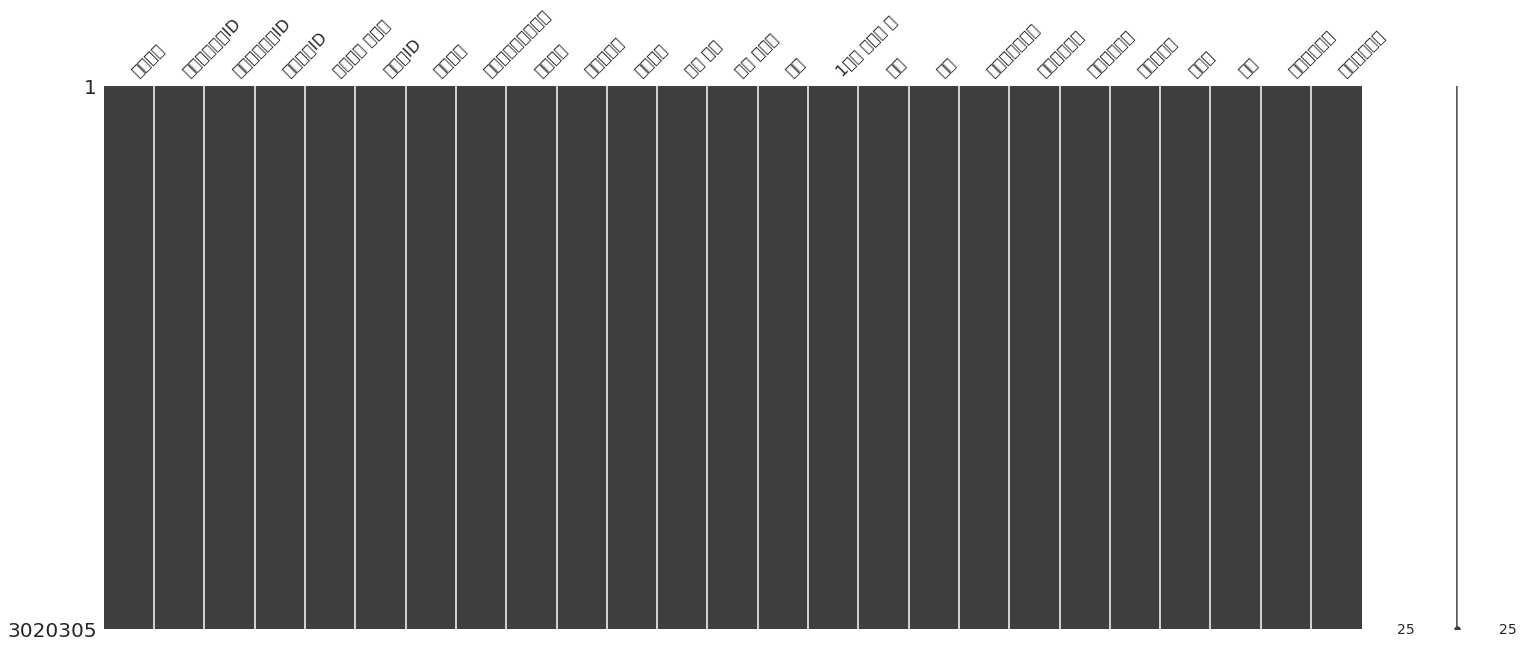

In [60]:
msno.matrix(df=df)

In [61]:
seoul = df[df['광역시도명'] == '서울특별시']

seoul['시군구명'].unique()

array(['동작구', '구로구', '금천구', '영등포구', '성북구', '은평구', '관악구', '양천구', '서초구',
       '강북구', '강서구', '서대문구', '마포구', '강동구', '중랑구', '중구', '동대문구', '용산구'],
      dtype=object)